# Generating Weekday and Weekend profiles

In [193]:
import polars as pl
import glob
import numpy as np
import os
from importlib import reload
import matplotlib.pyplot as plt

from kmodes.kprototypes import KPrototypes
import pandas as pd
import cluster_statistics_kProt
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [194]:
dataset = "SWW"    # Options: "SWW", "GroupE"
building_type = "house" # "flat", "house", "all"
categorical_features = "sociodemographic" # "technical" or "sociodemographic"
number_of_clusters = 5
weighting_gamma = 3

In [195]:
pattern = (f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_hourlyAveraged_normalized/*.csv')
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

for file_path in file_paths:
    df = pl.read_csv(file_path)

    base = os.path.basename(file_path)        # z.B. "10030.csv"
    resid, _ = os.path.splitext(base)         # "10030"

    if len(df) != n_timestamps:
        continue

    values_array = (
        df["day_avg_bruttolastgang_kwh"]
        .to_numpy()
        .reshape((1, n_timestamps, 1))
    )
    data_list.append(values_array)
    filename_list.append(resid)

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")
    train_data = data_3d
else:
    train_data = None
    print("No matching files with correct length found.")

train_data = data_3d
n_samples = data_3d.shape[0]

Shape of the 3D array: (1481, 96, 1)


In [196]:
# Load the Excel file
file_path = (f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/Survey_Data/Survey_Data_{dataset}.xlsx")

if dataset == "SWW":
    df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None,dtype={10: str})
    cols_to_extract = [10, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 154, 127, 129, 155, 131, 128, 156, 157, 158, 159, 160]
elif dataset == "GroupE":
    df = pd.read_excel(file_path, skiprows=3, nrows=1500, header=None,dtype={0: str})
    cols_to_extract = [0, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 160, 134, 136, 161, 138, 135, 162, 163, 154, 155, 166]

extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['resident_id', 'Building Type', 'Heating', 'Water Heating', 
                        'Solar Panels', 'Electric Vehicle', 'Heat Pump', 'Individual Electric Boiler', 
                        'Individual Washing Machine', 'Home Battery','Number of Residents',
                        'Number of Days at Home','Age','Education', 'Employment', 'Tenant Type',
                        'Income','DR scenario', 'DR heating', 'DR hot water', 'DR EV', 'DR appliances']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_house_ids = extracted_df_pl["resident_id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique resident_id count: {unique_house_ids}")

if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate resident_id entries.")
else:
    print("No duplicates found in resident_id column.")

Total rows: 1500
Unique resident_id count: 1500
No duplicates found in resident_id column.


In [197]:
#read the file according to the filenames extracted before

result_df = extracted_df
result_df = pl.from_pandas(result_df)
extracted_df = pl.from_pandas(extracted_df)

order_dict = {resident_id: i for i, resident_id in enumerate(filename_list)}
ordered_rows = [result_df.filter(pl.col("resident_id") == filename) for filename in filename_list]
ordered_result_df = pl.concat(ordered_rows)

In [ ]:
from pandas.api.types import CategoricalDtype


if categorical_features == "technical":
    if building_type == "house":
        # Load categorical column as pandas category
        category_df = ordered_result_df.select(['Building Type', 'Solar Panels', 'Electric Vehicle','Heating', 
                                            'Water Heating', 'Home Battery']).to_pandas().astype('category')
    
    elif building_type == "flat":
        # Load categorical column as pandas category
        category_df = ordered_result_df.select(['Building Type', 'Individual Electric Boiler', 
                                            'Individual Washing Machine']).to_pandas().astype('category')
        
else:
    category_df = ordered_result_df.select(['Building Type','Tenant Type', 'Age', 'Income', 'Education', 
                                        'Employment', 'Number of Residents','Number of Days at Home']).to_pandas().astype('category')


days_at_home_categories = ['No Information', '<25%', '25-50%', '>50-75%', '>75%']
building_type_categories = ['No Information', 'Flat', 'House']
heating_categories = ['No Information', 'Other', 'Heat Pump', 'Boiler']
water_heating_categories = ['No Information', 'Other', 'Heat Pump', 'Boiler']
solar_panels_categories = ['No Information', 'No', 'Yes']
electric_vehicle_categories = ['No Information', 'No', 'Yes']
number_of_days_at_home_categories = ['No Information', '0', '1', '2', '3', '4', '5', '6', '7']
home_battery_categories = ['No Information', 'No', 'Yes']
heat_pump_categories = ['No Information', 'No', 'Yes']

electric_boiler_categories = ['No Information', 'No', 'Yes']
washing_machine_categories = ['No Information', 'No', 'Yes']

building_type_categories = ['No Information', 'Flat', 'House']
tenant_type_categories = ['Living in a cooperative', 'Tenant', 'Owner']
age_categories = ['18-35 years old', '36 - 50 years old', '51 - 65 years old', 'More than 65 years old']
income_categories = ['I prefer not to say', 'Less than 4,000', '4,000-5,999','6000-9999','10000 CHF or more' ]
education_categories = ['Mandatory school', 'Secondary degree (Apprenticeship, high school et commercial/general culture school)'
                        , 'Tertiary degree  (Superior school (ES), University/EPF, vocational university)']
employment_categories = ['Employed', 'Unemployed', 'Retired']
number_of_residents_categories = ['1', '2', '3', '4', '> 4']
number_of_days_at_home_categories = ['0', '1', '2', '3', '4', '5', '6', '7']

building_cat_type = CategoricalDtype(categories=building_type_categories, ordered=True)
heating_cat_type = CategoricalDtype(categories=heating_categories, ordered=True)
water_heating_cat_type = CategoricalDtype(categories=water_heating_categories, ordered=True)
solar_cat_type = CategoricalDtype(categories=solar_panels_categories, ordered=True)
ev_cat_type = CategoricalDtype(categories=electric_vehicle_categories, ordered=True)
number_of_days_cat_type = CategoricalDtype(categories=number_of_days_at_home_categories, ordered=True)
home_battery_cat_type = CategoricalDtype(categories=home_battery_categories, ordered=True)
heat_pump_cat_type = CategoricalDtype(categories=heat_pump_categories, ordered=True)

electric_boiler_cat_type = CategoricalDtype(categories=electric_boiler_categories, ordered=False)
washing_machine_cat_type = CategoricalDtype(categories=washing_machine_categories, ordered=False)


building_cat_type = CategoricalDtype(categories=building_type_categories, ordered=True)
tenant_cat_type = CategoricalDtype(categories=tenant_type_categories, ordered=True)
age_cat_type = CategoricalDtype(categories=age_categories, ordered=True)
income_cat_type = CategoricalDtype(categories=income_categories, ordered=True)
education_cat_type = CategoricalDtype(categories=education_categories, ordered=True)
employment_cat_type = CategoricalDtype(categories=employment_categories, ordered=True)
number_of_residents_cat_type = CategoricalDtype(categories=number_of_residents_categories, ordered=True)
number_of_days_at_home_cat_type = CategoricalDtype(categories=number_of_days_at_home_categories, ordered=True)



if categorical_features == "technical":
    if building_type == "house":
        category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
        category_df['Heating'] = category_df['Heating'].astype(heating_cat_type)
        category_df['Water Heating'] = category_df['Water Heating'].astype(water_heating_cat_type)
        category_df['Solar Panels'] = category_df['Solar Panels'].astype(solar_cat_type)
        category_df['Electric Vehicle'] = category_df['Electric Vehicle'].astype(ev_cat_type)
        category_df['Home Battery'] = category_df['Home Battery'].astype(home_battery_cat_type)
    elif building_type == "flat":
        category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
        category_df['Individual Electric Boiler'] = category_df['Individual Electric Boiler'].astype(electric_boiler_cat_type)
        category_df['Individual Washing Machine'] = category_df['Individual Washing Machine'].astype(washing_machine_cat_type)

else:
    category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
    category_df['Tenant Type'] = category_df['Tenant Type'].astype(tenant_cat_type)
    category_df['Age'] = category_df['Age'].astype(age_cat_type)
    category_df['Income'] = category_df['Income'].astype(income_cat_type)
    category_df['Education'] = category_df['Education'].astype(education_cat_type)
    category_df['Employment'] = category_df['Employment'].astype(employment_cat_type)
    category_df['Number of Residents'] = category_df['Number of Residents'].astype(number_of_residents_cat_type)
    category_df['Number of Days at Home'] = category_df['Number of Days at Home'].astype(number_of_days_at_home_cat_type)

rows_to_keep_indices = []

exclude_building_type = building_type

if building_type == "all":
    exclude_building_type = None
elif building_type == "house":
    exclude_building_type = "Flat"
elif building_type == "flat":
    exclude_building_type = "House"

if building_type != "all":
    for i, row in category_df.iterrows():
        # Check if 'No Information' NOT in any value of that row
        if "No Information" not in row.values:
            # Check if 'Flat' NOT in any value of that row
            if exclude_building_type not in row.values:
                rows_to_keep_indices.append(i)
else:
    for i, row in category_df.iterrows():
        rows_to_keep_indices.append(i)

category_df = category_df.drop(columns=['Building Type'])

#print(category_df.iloc[rows_to_keep_indices])

for col in category_df.columns:
    category_df[col] = category_df[col].cat.codes

# Convert to NumPy array
category_array = category_df.to_numpy()

# Numeric time series shaped as (n_samples, n_timestamps)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# Combine horizontally
combined_data = np.hstack([time_series_numeric, category_df])

# Filter both arrays using the collected indices to keep
cleaned_combined_data = combined_data[rows_to_keep_indices]
time_series_numeric = time_series_numeric[rows_to_keep_indices]
combined_data = cleaned_combined_data

filename_list = [filename_list[i] for i in rows_to_keep_indices]

In [199]:
%%skip
from pandas.api.types import CategoricalDtype

# Load categorical column as pandas category
category_df = ordered_result_df.select(['Building Type','Tenant Type', 'Age', 'Income', 'Education', 
                                        'Employment', 'Number of Residents','Number of Days at Home']).to_pandas().astype('category')



#category_df['Number of Days at Home'] = category_df['Number of Days at Home'].astype(str)

building_type_categories = ['No Information', 'Flat', 'House']
tenant_type_categories = ['Living in a cooperative', 'Tenant', 'Owner']
age_categories = ['18-35 years old', '36 - 50 years old', '51 - 65 years old', 'More than 65 years old']
income_categories = ['I prefer not to say', 'Less than 4,000', '4,000-5,999','6000-9999','10000 CHF or more' ]
education_categories = ['Mandatory school', 'Secondary degree (Apprenticeship, high school et commercial/general culture school)'
                        , 'Tertiary degree  (Superior school (ES), University/EPF, vocational university)']
employment_categories = ['Employed', 'Unemployed', 'Retired']
number_of_residents_categories = ['1', '2', '3', '4', '> 4']
number_of_days_at_home_categories = ['0', '1', '2', '3', '4', '5', '6', '7']

building_cat_type = CategoricalDtype(categories=building_type_categories, ordered=True)
tenant_cat_type = CategoricalDtype(categories=tenant_type_categories, ordered=True)
age_cat_type = CategoricalDtype(categories=age_categories, ordered=True)
income_cat_type = CategoricalDtype(categories=income_categories, ordered=True)
education_cat_type = CategoricalDtype(categories=education_categories, ordered=True)
employment_cat_type = CategoricalDtype(categories=employment_categories, ordered=True)
number_of_residents_cat_type = CategoricalDtype(categories=number_of_residents_categories, ordered=True)
number_of_days_at_home_cat_type = CategoricalDtype(categories=number_of_days_at_home_categories, ordered=True)

category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
category_df['Tenant Type'] = category_df['Tenant Type'].astype(tenant_cat_type)
category_df['Age'] = category_df['Age'].astype(age_cat_type)
category_df['Income'] = category_df['Income'].astype(income_cat_type)
category_df['Education'] = category_df['Education'].astype(education_cat_type)
category_df['Employment'] = category_df['Employment'].astype(employment_cat_type)
category_df['Number of Residents'] = category_df['Number of Residents'].astype(number_of_residents_cat_type)
category_df['Number of Days at Home'] = category_df['Number of Days at Home'].astype(number_of_days_at_home_cat_type)



rows_to_keep_indices = []

for i, row in category_df.iterrows():
    # Check if 'No Information' NOT in any value of that row
    if "No Information" not in row.values:
        # Check if 'Flat' NOT in any value of that row
        if "Flat" not in row.values:
            rows_to_keep_indices.append(i)

category_df = category_df.drop(columns=['Building Type'])

#rows_to_keep_indices = save_rows_to_keep

print(category_df.iloc[rows_to_keep_indices])

for col in category_df.columns:
    category_df[col] = category_df[col].cat.codes

# Convert to NumPy array
category_array = category_df.to_numpy()

print(category_array)

# Numeric time series shaped as (n_samples, n_timestamps)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# Combine horizontally
combined_data = np.hstack([time_series_numeric, category_df])

# Filter both arrays using the collected indices to keep
cleaned_combined_data = combined_data[rows_to_keep_indices]
time_series_numeric = time_series_numeric[rows_to_keep_indices]
combined_data = cleaned_combined_data

filename_list = [filename_list[i] for i in rows_to_keep_indices]


print(len(combined_data))
print(combined_data)

In [200]:
# 5. Specify the categorical feature column indices (the last 7 columns)


if categorical_features == "technical":
    if building_type == "house":
        number_of_categories = 5
    else:
        number_of_categories = 2
else:
    number_of_categories = 7

categorical_indices = list(range(combined_data.shape[1] - number_of_categories, combined_data.shape[1]))
numerical_indices = list(range(0, combined_data.shape[1]-number_of_categories))

In [201]:
%%skip

import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes

cluster_range = range(1, 9)  # Try 2-10 clusters
gamma_range = np.linspace(0.0, 3.5, 8)

# Store costs for each gamma value; key: gamma, value: list of costs per cluster count
costs_dict = {}

for gamma in gamma_range:
    costs_for_gamma = []
    for n_clusters in cluster_range:
        kproto = KPrototypes(
            n_clusters=n_clusters,
            init='Cao',
            verbose=0,
            max_iter=500,
            gamma=gamma,  # use current gamma value
            random_state=42,
            n_init=10
        )
        kproto.fit_predict(combined_data, categorical=categorical_indices)
        costs_for_gamma.append(kproto.cost_)
        #print(f"Clusters: {n_clusters}, Gamma: {gamma:.2f}, Cost: {kproto.cost_}")
    costs_dict[gamma] = costs_for_gamma

# Plot costs per cluster for each gamma line
plt.figure(figsize=(10, 6))
for gamma, costs_for_gamma in costs_dict.items():
    plt.plot(cluster_range, costs_for_gamma, marker='o', label=f'Gamma={gamma:.2f}')

plt.xlabel('Number of clusters')
plt.ylabel('K-Prototypes cost [-]')
plt.ylim(0, max(max(c) for c in costs_dict.values()) * 1.1)
plt.title('K-Prototypes Cost per Cluster Number for Different Gamma Values - Houses')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend(title='Weighting')
plt.tight_layout()
plt.savefig(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/kPrototypes_cost_{building_type}.png')
plt.show()

In [202]:
%%skip

n_clusters = number_of_clusters
gamma_range = np.linspace(0, 3, 31)  # Example: 21 values from 0 to 2

numerical_costs = []
categorical_costs = []
total_weighted_cost = []

for gamma in gamma_range:
    kproto = KPrototypes(
        n_clusters=n_clusters,
        init='Cao',
        verbose=0,
        max_iter=500,
        gamma=gamma,
        random_state=42,
        n_init=10
    )
    
    clusters = kproto.fit_predict(combined_data, categorical=categorical_indices)
    
    total_num_cost = 0
    total_cat_cost = 0
    
    centroids_num = kproto.cluster_centroids_[:, numerical_indices].astype(float)
    centroids_cat = kproto.cluster_centroids_[:, categorical_indices].astype(str)
    
    for i in range(combined_data.shape[0]):
        label = clusters[i]
        sample_num = combined_data[i, numerical_indices].astype(float)
        sample_cat = combined_data[i, categorical_indices].astype(str)
        
        dist_num = np.sum((sample_num - centroids_num[label]) ** 2)
        dist_cat = np.sum(sample_cat != centroids_cat[label])
        
        total_num_cost += dist_num
        total_cat_cost += dist_cat
    
    # Store average cost per sample for plotting
    numerical_costs.append(total_num_cost)
    categorical_costs.append(total_cat_cost)
    total_weighted_cost.append(total_cat_cost*gamma+total_num_cost)
    
    print(f"Gamma={gamma:.2f}, Numerical Cost={numerical_costs[-1]:.2f}, Categorical Cost={categorical_costs[-1]:.2f}")

# Plot numerical and categorical costs against gamma
plt.figure(figsize=(10, 6))
plt.plot(gamma_range, numerical_costs, label='Numerical Cost', marker='o')
plt.plot(gamma_range, categorical_costs, label='Categorical Cost', marker='s')
plt.plot(gamma_range, total_weighted_cost, label='Total weighted Cost', marker='s')
plt.xlabel('Gamma')
plt.ylabel('Average Cost per Sample')
plt.title(f'Numerical and Categorical Costs vs Gamma (Clusters={n_clusters})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [203]:
%%skip

import numpy as np
import matplotlib.pyplot as plt
from kmodes import kprototypes
from sklearn.metrics import silhouette_score

categorical = categorical_indices  # e.g., [0, 2, 4]
gamma_values = np.linspace(0, 4, 9)     # gamma = 0 to 9
cluster_values = range(2, 11)        # number of clusters from 2 to 7
silhouette_scores = np.zeros((len(cluster_values), len(gamma_values)))

def mixed_distance(a, b, categorical, gamma):
    num_idx = [i for i in range(len(a)) if i not in categorical]
    num_dist = np.sum((a[num_idx] - b[num_idx]) ** 2)
    cat_dist = np.sum(a[categorical] != b[categorical])
    return num_dist + gamma * cat_dist

def create_distance_matrix(X, categorical, gamma):
    n = X.shape[0]
    dm = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = mixed_distance(X[i], X[j], categorical, gamma)
            dm[i, j] = dm[j, i] = d
    return dm

for i, n_clusters in enumerate(cluster_values):
    for j, gamma in enumerate(gamma_values):
        distance_matrix = create_distance_matrix(combined_data, categorical, gamma)
        model = kprototypes.KPrototypes(n_clusters=n_clusters, gamma=gamma,random_state=42,n_init=10)
        labels = model.fit_predict(combined_data, categorical=categorical)
        score = silhouette_score(distance_matrix, labels, metric="precomputed")
        silhouette_scores[i, j] = score
        #print(f"Clusters: {n_clusters}, Gamma: {gamma}, Silhouette Score: {score:.3f}")

# Plot results: multiple curves of silhouette score for each cluster number
plt.figure(figsize=(10, 6))
for j, gamma in enumerate(gamma_values):
    plt.plot(cluster_values, silhouette_scores[:, j], marker='o', label=f'Gamma={gamma}')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters for Different Gamma Values - Houses')
plt.legend()
plt.grid(True)
plt.savefig(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/kPrototypes_SC_{building_type}.png')
plt.show()

In [204]:
#%%skip

from kmodes import kprototypes
from sklearn.metrics import silhouette_score
import numpy as np

def mixed_distance(a, b, categorical, gamma):
    num_idx = [i for i in range(len(a)) if i not in categorical]
    num_dist = np.sum((a[num_idx] - b[num_idx]) ** 2)
    cat_dist = np.sum(a[categorical] != b[categorical])
    return num_dist + gamma * cat_dist

def create_distance_matrix(X, categorical, gamma):
    n = X.shape[0]
    dm = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = mixed_distance(X[i], X[j], categorical, gamma)
            dm[i, j] = dm[j, i] = d
    return dm

# Suppose X is your data (after preprocessing, as used with K-Prototypes)
categorical = categorical_indices  # replace with your categorical column indices
gamma = weighting_gamma  # use the value from your model

distance_matrix = create_distance_matrix(combined_data, categorical, gamma)

# Fit K-Prototypes and get labels:
model = kprototypes.KPrototypes(n_clusters=number_of_clusters, gamma=gamma)
labels = model.fit_predict(combined_data, categorical=categorical)

# Compute silhouette score:
from sklearn.metrics import silhouette_score
score = silhouette_score(distance_matrix, labels, metric="precomputed")
print("Silhouette score:", score)

Silhouette score: 0.15249790617104886


In [205]:
# 6. Initialize and run K-Prototypes clustering
kproto = KPrototypes(
    n_clusters=number_of_clusters, 
    init='Cao', 
    verbose=0, 
    max_iter=500, 
    gamma=weighting_gamma,
    random_state=42,
    n_init=10
)

clusters = kproto.fit_predict(combined_data, categorical=categorical_indices)

clusters = clusters + 1

In [206]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
resident_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "resident_id": resident_ids,
    "cluster": clusters
}).sort("cluster")

result_df.write_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/DATA/Cluster/hourly_avg_clustering_kProt_{building_type}.csv")

Cluster 1 size: 115
Cluster 2 size: 92
Cluster 3 size: 96
Cluster 4 size: 107
Cluster 5 size: 66


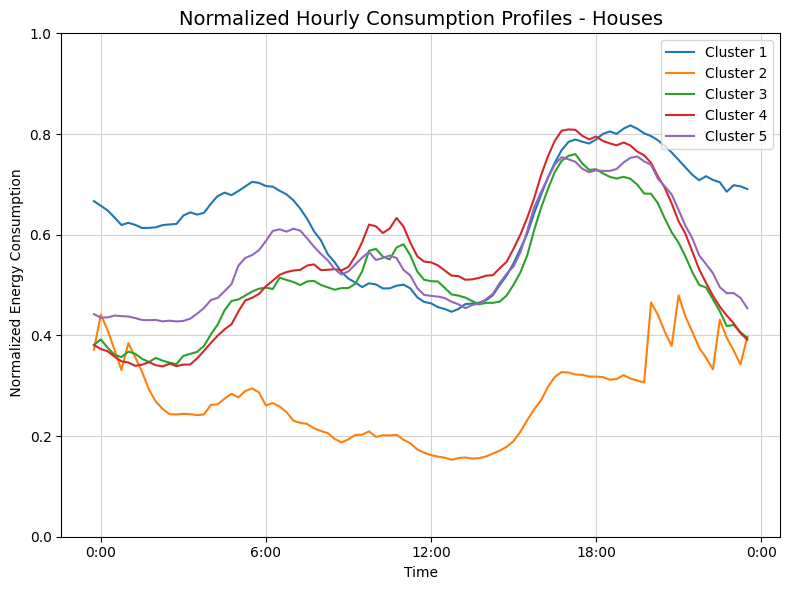

In [207]:
unique_clusters = np.unique(clusters)

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

plt.figure(figsize=(8, 6))
for cl in unique_clusters:
    idx = np.where(clusters == cl)[0]
    avg_profile = time_series_numeric[idx].mean(axis=0)
    plt.plot(avg_profile, label=f'Cluster {cl}')
    print(f'Cluster {cl} size: {len(idx)}')

plt.title("Normalized Hourly Consumption Profiles - Houses", fontsize=14)
plt.xlabel("Time")
plt.ylabel(" Normalized Energy Consumption")
plt.ylim(0,1)
#plt.xticks(range(1,108,12),labels=labels)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
#plt.legend()
#plt.margins(0)
plt.grid(True, color = 'lightgray')
plt.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Adjust this value for vertical position
    ncol=1,
    fontsize='medium'
)
plt.savefig(
    f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/HourlyAveraged_KProt_{building_type}.png",
    bbox_inches='tight'
    )
plt.show()



(476, 96, 1)


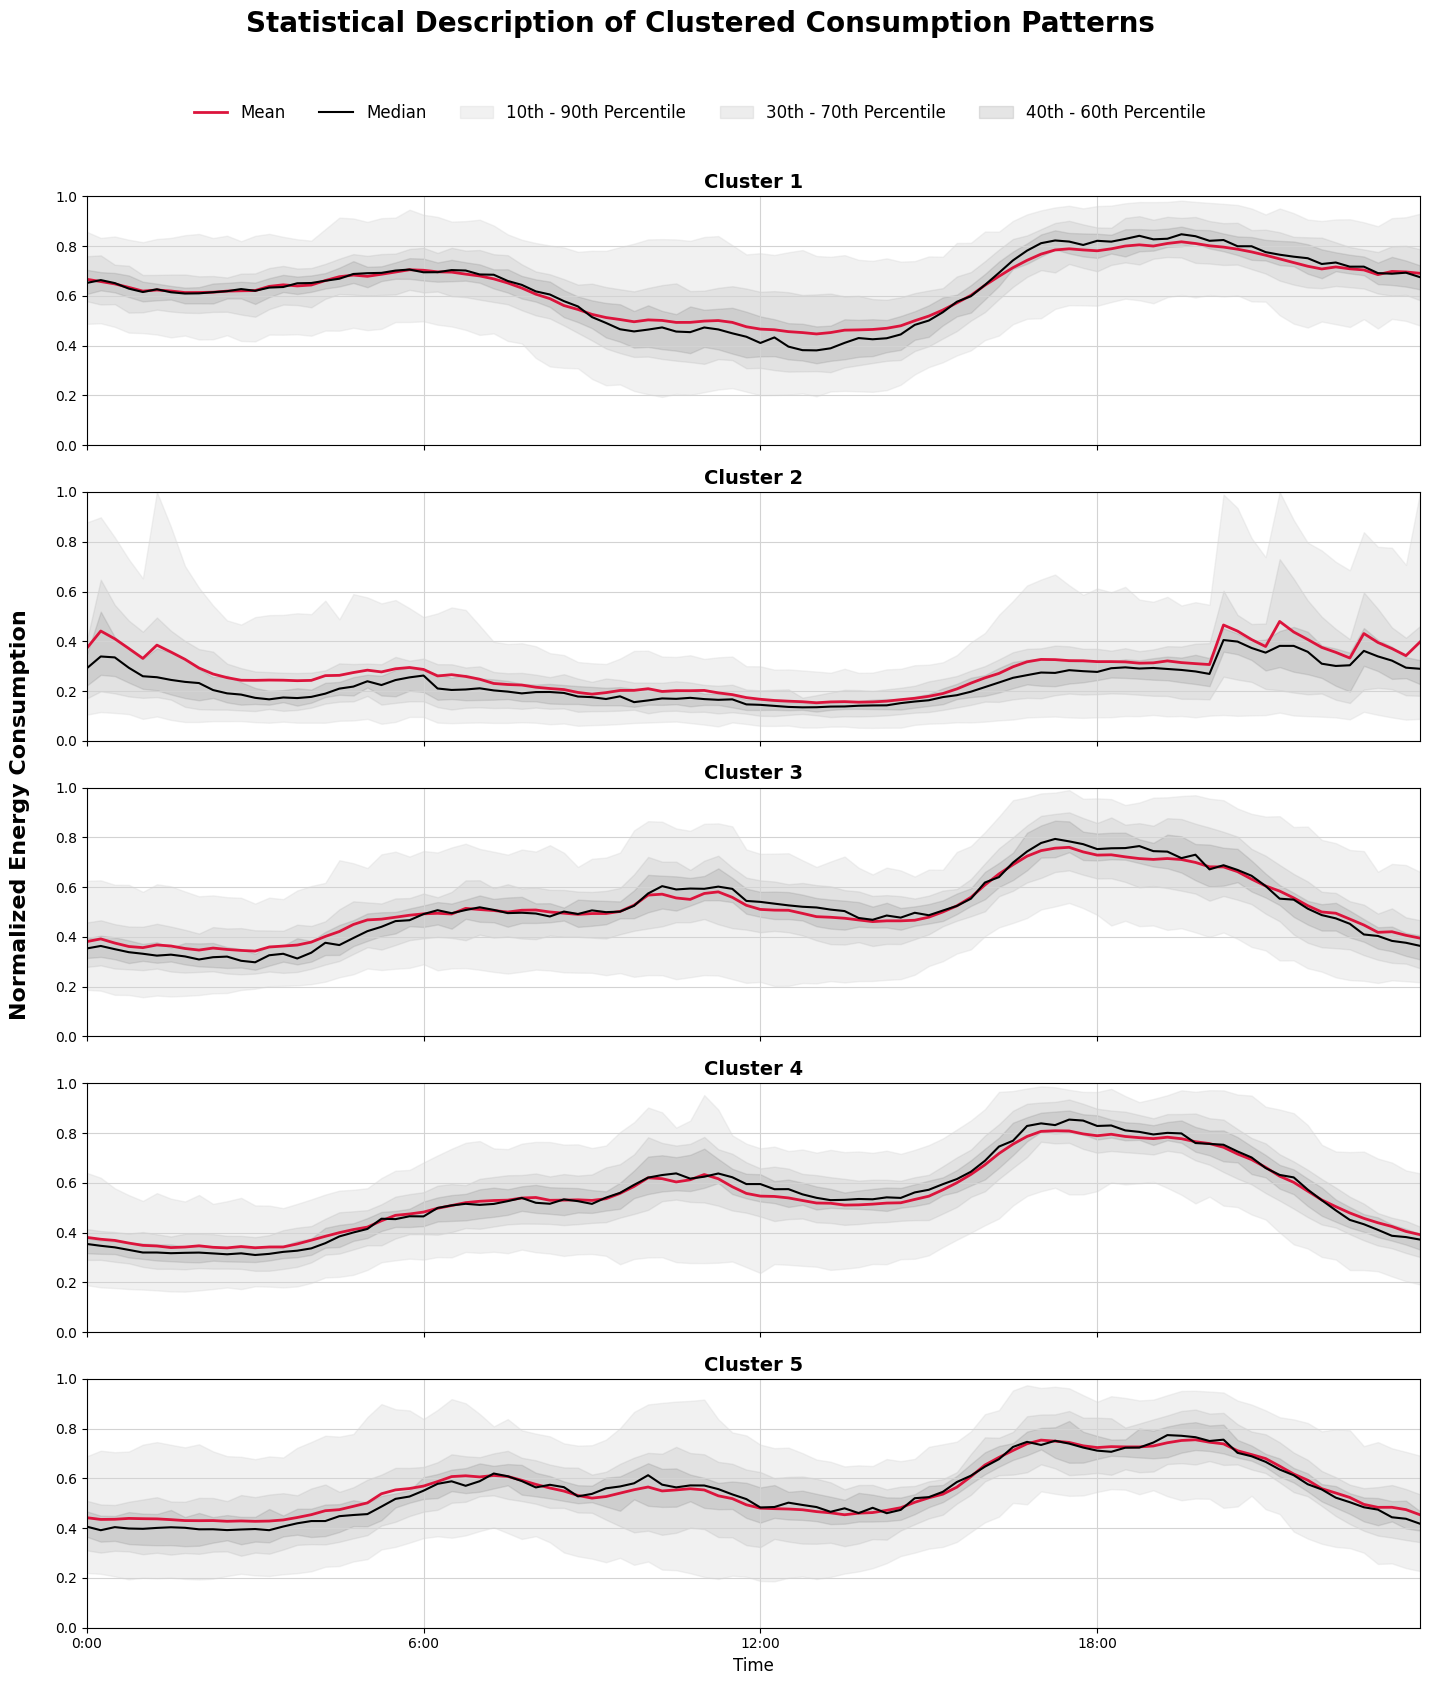

In [208]:
#%%skip

reload(cluster_statistics_kProt)

from cluster_statistics_kProt import plot_cluster_percentiles

data_3d_kProt = np.expand_dims(time_series_numeric, axis=-1)

print(data_3d_kProt.shape)

#print(data_3d_kProt)

for i in range(number_of_clusters):

    i = i+1
    # Select samples for the current cluster
    cluster_data = time_series_numeric[clusters == i]
    
    if cluster_data.shape[0] == 0:
        print(f"Warning: cluster {i} is empty, skipping.")
        continue  # Skip this cluster

plot_cluster_percentiles(data_3d_kProt,clusters,number_of_clusters, building_type, dataset)

In [209]:
result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/DATA/Cluster/hourly_avg_clustering_kProt_{building_type}.csv')

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/alle_mittelwerte.csv") 

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("resident_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "resident_id",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption",
        "average_hourly_consumption",
        "bruttolastgang_kwh_max"
    ]),
    on="resident_id",
    how="left"
)
result_df = result_df.select([
    "resident_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption" ,
    "average_hourly_consumption",
    "bruttolastgang_kwh_max"
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("resident_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2),
    pl.mean("average_hourly_consumption").alias("avg_hourly_consumption [kWh]").round(2),
    pl.mean("bruttolastgang_kwh_max").alias("avg_max_consumption [kWh]").round(2)
    
]).sort("cluster")

cluster_summary = cluster_summary.with_columns([
    (pl.col("avg_total_consumption [kWh]") * pl.col("num_households")/1000)
        .alias("combined_max_consumption [MWh]")
        .round(2),
    (pl.col("avg_total_consumption [kWh]") * pl.col("num_households"))
        .alias("cluster_total_consumption [kWh]"),
])

cluster_summary = cluster_summary.with_columns([
    (pl.col("num_households") / pl.col("num_households").sum())
        .alias("share_of_households")
        .round(2),
    (pl.col("cluster_total_consumption [kWh]") 
     / pl.col("cluster_total_consumption [kWh]").sum())
        .alias("share_of_total_consumption")
        .round(2),
])

print(cluster_summary)

shape: (5, 10)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ cluster ┆ num_househ ┆ avg_total ┆ avg_daily ┆ … ┆ combined_ ┆ cluster_t ┆ share_of_ ┆ share_of_ │
│ ---     ┆ olds       ┆ _consumpt ┆ _consumpt ┆   ┆ max_consu ┆ otal_cons ┆ household ┆ total_con │
│ i64     ┆ ---        ┆ ion [kWh] ┆ ion [kWh] ┆   ┆ mption    ┆ umption   ┆ s         ┆ sumption  │
│         ┆ u32        ┆ ---       ┆ ---       ┆   ┆ [MWh]     ┆ [kWh…     ┆ ---       ┆ ---       │
│         ┆            ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64       │
│         ┆            ┆           ┆           ┆   ┆ f64       ┆ f64       ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1       ┆ 115        ┆ 9966.06   ┆ 16.23     ┆ … ┆ 1146.1    ┆ 1146096.9 ┆ 0.24      ┆ 0.3       │
│ 2       ┆ 92         ┆ 9007.15   ┆ 14.71     ┆ … ┆ 828.66    ┆ 828657.8  ┆

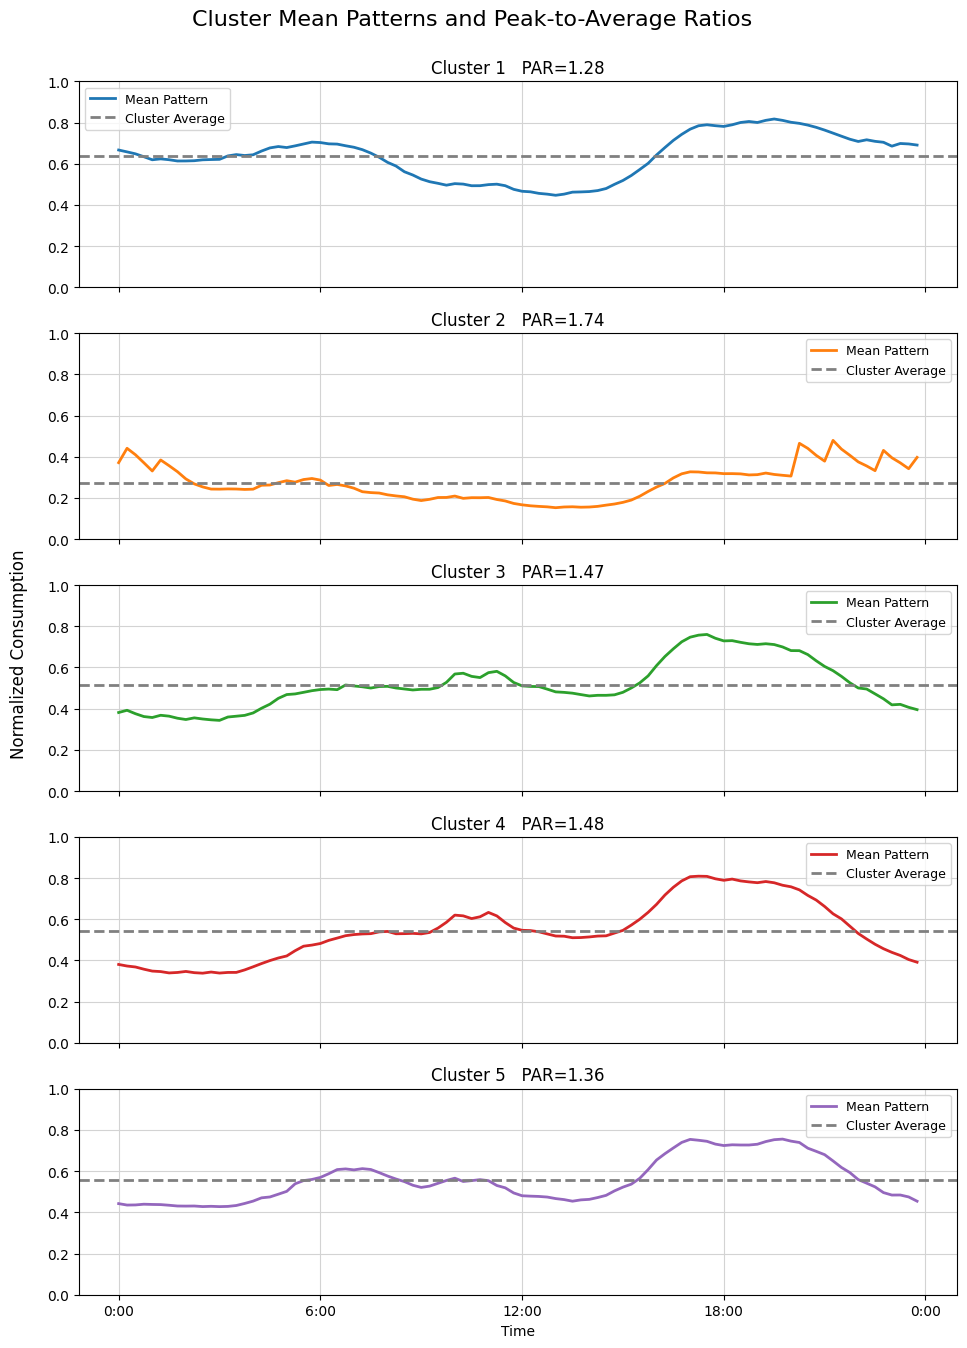

In [210]:
labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

n_clusters_to_plot = np.unique(clusters)
n_clusters = len(n_clusters_to_plot)

fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 2.8 * n_clusters), sharex=True)

if n_clusters == 1:
    axes = [axes]

for idx, cl in enumerate(sorted(n_clusters_to_plot)):  # Cluster 1 oben
    cluster_idx = np.where(clusters == cl)[0]
    mean_time_series = time_series_numeric[cluster_idx].mean(axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)

    ax = axes[idx]
    ax.plot(range(1,97), mean_time_series.ravel()[:96],
            label='Mean Pattern', linewidth=2, color=colors[cl-1])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cl}   PAR={PAR_max/PAR_average:.2f}",
                 loc='center', fontsize=12, color='black')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.grid(color='lightgray', zorder=0)
    ax.legend(fontsize=9)
    if idx == n_clusters-1:
        ax.set_xlabel("Time")
        ax.set_xticks(range(1,120,24))
        ax.set_xticklabels(labels)
    else:
        ax.set_xticks([]) # Remove x-ticks for all but the last subplot

fig.suptitle("Cluster Mean Patterns and Peak-to-Average Ratios", fontsize=16,  y=0.96)
fig.text(0.038, 0.5, "Normalized Consumption", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 0.96])
plt.savefig(
    f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/PAR_KProt_{building_type}.png",
    bbox_inches='tight'
)
plt.show()

In [211]:
# Create DataFrame with cluster labels and decoded categorical feature

if categorical_features == "technical":    
    if building_type == "flat":
        df = pd.DataFrame({
            'cluster': clusters,
            'Individual Electric Boiler': [electric_boiler_categories[int(code)] for code in combined_data[:, -2]],
            'Individual Washing Machine': [washing_machine_categories[int(code)] for code in combined_data[:, -1]]
        })
    

    else:  
        df = pd.DataFrame({
            'cluster': clusters,
            'Solar Panels': [solar_panels_categories[int(code)] for code in combined_data[:, -5]],
            'Electric Vehicle': [electric_vehicle_categories[int(code)] for code in combined_data[:, -4]],
            'Heating': [heating_categories[int(code)] for code in combined_data[:, -3]],
            'Water Heating': [water_heating_categories[int(code)] for code in combined_data[:, -2]],
            'Home Battery': [home_battery_categories[int(code)] for code in combined_data[:, -1]]
        })

else:
    df = pd.DataFrame({
    'cluster': clusters,
    'Tenant Type': [tenant_type_categories[int(code)] for code in combined_data[:, -7]],
    'Age': [age_categories[int(code)] for code in combined_data[:, -6]],
    'Income': [income_categories[int(code)] for code in combined_data[:, -5]],
    'Education': [education_categories[int(code)] for code in combined_data[:, -4]],
    'Employment': [employment_categories[int(code)] for code in combined_data[:, -3]],
    'Number of Residents': [number_of_residents_categories[int(code)] for code in combined_data[:, -2]],
    'Number of Days at Home': [number_of_days_at_home_categories[int(code)] for code in combined_data[:, -1]]
})

print(df.head())

   cluster Tenant Type                Age               Income  \
0        2      Tenant  51 - 65 years old  I prefer not to say   
1        3       Owner  36 - 50 years old  I prefer not to say   
2        4      Tenant  51 - 65 years old    10000 CHF or more   
3        4       Owner  51 - 65 years old            6000-9999   
4        4      Tenant  51 - 65 years old      Less than 4,000   

                                           Education Employment  \
0  Tertiary degree  (Superior school (ES), Univer...   Employed   
1  Tertiary degree  (Superior school (ES), Univer...   Employed   
2  Tertiary degree  (Superior school (ES), Univer...   Employed   
3  Tertiary degree  (Superior school (ES), Univer...   Employed   
4  Tertiary degree  (Superior school (ES), Univer...   Employed   

  Number of Residents Number of Days at Home  
0                   2                      7  
1                   4                      7  
2                   1                      7  
3           

In [212]:
%%skip
df = pd.DataFrame({
    'cluster': clusters,
    'Tenant Type': [tenant_type_categories[int(code)] for code in combined_data[:, -7]],
    'Age': [age_categories[int(code)] for code in combined_data[:, -6]],
    'Income': [income_categories[int(code)] for code in combined_data[:, -5]],
    'Education': [education_categories[int(code)] for code in combined_data[:, -4]],
    'Employment': [employment_categories[int(code)] for code in combined_data[:, -3]],
    'Number of Residents': [number_of_residents_categories[int(code)] for code in combined_data[:, -2]],
    'Number of Days at Home': [number_of_days_at_home_categories[int(code)] for code in combined_data[:, -1]]
})
print(df.head())

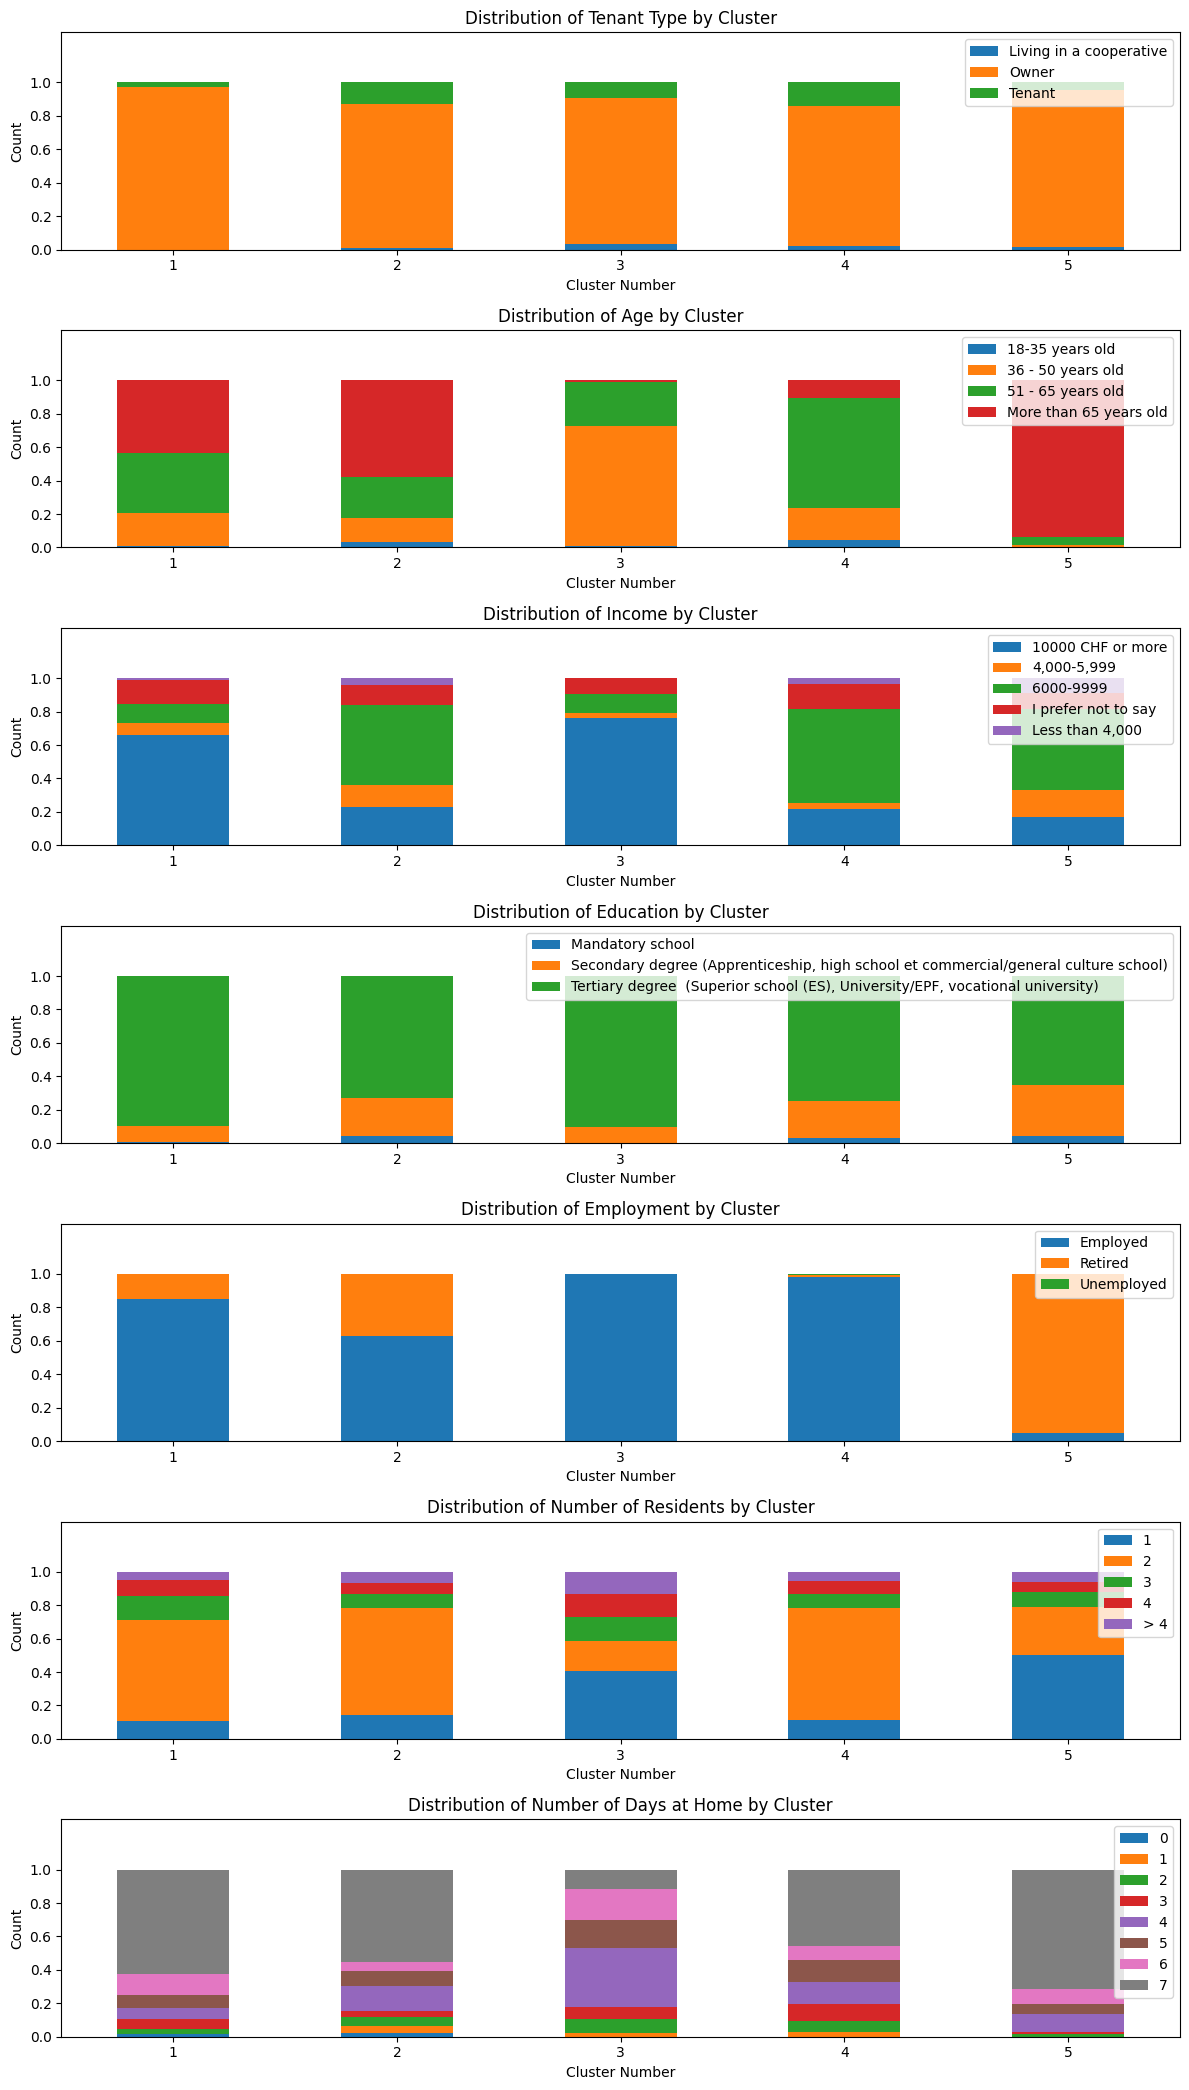

In [213]:
# Number of categorical features to plot

if categorical_features == "technical":
    if building_type == "flat":
        category_features = ['Individual Electric Boiler', 'Individual Washing Machine']

    else:
        category_features = ['Heating', 'Water Heating', 'Solar Panels', 'Electric Vehicle', 'Home Battery']

else:
    category_features = ['Tenant Type', 'Age', 'Income', 'Education', 'Employment', 'Number of Residents', 'Number of Days at Home' ]

n_features = len(category_features)
fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features))

if n_features == 1:
    axes = [axes]

for i, feature in enumerate(category_features):
    ax = axes[i]
    # Group and pivot data for plotting
    counts = df.groupby(['cluster', feature]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Plot stacked bar chart
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and labels
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_ylabel('Count')
    ax.set_xlabel('Cluster Number')
    ax.set_ylim(0, 1.3)  # y-axis goes only up to 1.15 (bars max out at 1, extra space for DR titles)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    
    # Rotate x-ticks for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Adjust this value for vertical position
    ncol=1,
    fontsize='medium'
)
#plt.savefig(
#f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Survey/categories_tech_house.png",
#bbox_inches='tight'
#)
plt.tight_layout()
plt.show()